In [1]:
%store -r

In [2]:
import os
import pathlib
from glob import glob
import requests

from math import floor, ceil

import earthaccess
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import rioxarray as rxr
import rioxarray.merge as rxrmerge
import xarray as xr
import xrspatial

c:\Users\tjsto\miniconda3\envs\earth-analytics-python\Lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [59]:
def set_buffer(boundary_gdf, buffer=0):
    """
    Increases the max bounds of a geo data frame by a set amount.
    Returns the max bounds as a tuple.
    """
    bounds = tuple(boundary_gdf.total_bounds)
    xmin, ymin, xmax, ymax = bounds
    bounds_buffer = (xmin-buffer, ymin-buffer, xmax+buffer, ymax+buffer)

    return bounds_buffer

In [ ]:
def process_image(file_pattern, boundary_gdf, buffer=0):
    """Load image, crop to study boundary, merge assays"""
    
    # Set a buffer to crop images to
    bounds_buffer = set_buffer(boundary_gdf, buffer)
    
    # Open and crop the images
    da_list = []
    for file_path in glob(file_pattern):
        tile_da = (
            rxr.open_rasterio(file_path, mask_and_scale=True)
            .squeeze())
        cropped_da = tile_da.rio.clip_box(*bounds_buffer)
        da_list.append(cropped_da)
    
    # Merge the list of cropped data arrays
    merged_da = rxrmerge.merge_arrays(da_list)
    
    # Returns a cropped and merged data array
    return merged_da

Fit a model: For each forest:

    Download model variables as raster layers covering your study area envelope, including:
        At least one soil variable from the POLARIS dataset
        Elevation from the SRTM (available from the earthaccess API)
        At least one climate variable from the MACAv2 THREDDS data server. Your project should compare two climate scenarios of your choice (e.g. different time periods, different emission scenarios). You can find a tutorial on how to access these climate data on earthdatascience.org


In [26]:
def download_tif(url, save_path):
    """Function to download and save .tif files"""
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(save_path, 'wb') as file:
            for chunk in response.iter_content(chunk_size=8192):
                file.write(chunk)
        print(f"Downloaded: {save_path}")
    else: 
        print(f"Failed to download {url}. Status code: {response.status_code}")

In [ ]:
def polaris_soil_data(variable, statistic, depth, gdf, save_folder):
    
    # Ensure the save directory exists
    polaris_dir = os.path.join(data_dir, 'polaris/'+save_folder)
    os.makedirs(polaris_dir, exist_ok=True)

    # Create list of soil data URLs
    soil_url_template = ("http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0"
                "/{variable}"
                "/{statistic}"
                "/{depth}"
                "/lat{min_lat}{max_lat}_lon{min_lon}{max_lon}.tif")

    bounds_min_lon, bounds_min_lat, bounds_max_lon, bounds_max_lat = (
        gdf.total_bounds)

    soil_url_list = []

    for lesser_lat in range(floor(bounds_min_lat), ceil(bounds_max_lat)):
        for lesser_lon in range(floor(bounds_min_lon), ceil(bounds_max_lon)):
            soil_url = soil_url_template.format(
                variable=variable,
                statistic=statistic,
                depth=depth,
                min_lat=lesser_lat, max_lat=lesser_lat+1, 
                min_lon=lesser_lon, max_lon=lesser_lon+1)
            soil_url_list.append(soil_url)

    # Download the files locally
    for url in soil_url_list:
        # Extract file name from url
        split_url = url.split("/")[-5:]
        filename = ''
        for i in split_url:
            filename+=i

        # Download the .tif file once
        save_path = os.path.join(polaris_dir, filename)
        if not os.path.exists(save_path):
            download_tif(url, save_path, buffer)


GWNF_soil_data = polaris_soil_data('ph', 'mean', '30_60', GWNF_gdf, 'GWNF')
JNF_soil_data = polaris_soil_data('ph', 'mean', '30_60', JNF_gdf, 'JNF')

Downloaded: C:\Users\tjsto\earth-analytics\data\habitat-suitability\polaris/GWNF\v1.0phmean30_60lat3738_lon-81-80.tif
Downloaded: C:\Users\tjsto\earth-analytics\data\habitat-suitability\polaris/GWNF\v1.0phmean30_60lat3738_lon-80-79.tif
Downloaded: C:\Users\tjsto\earth-analytics\data\habitat-suitability\polaris/GWNF\v1.0phmean30_60lat3738_lon-79-78.tif
Downloaded: C:\Users\tjsto\earth-analytics\data\habitat-suitability\polaris/GWNF\v1.0phmean30_60lat3839_lon-81-80.tif
Downloaded: C:\Users\tjsto\earth-analytics\data\habitat-suitability\polaris/GWNF\v1.0phmean30_60lat3839_lon-80-79.tif
Downloaded: C:\Users\tjsto\earth-analytics\data\habitat-suitability\polaris/GWNF\v1.0phmean30_60lat3839_lon-79-78.tif
Downloaded: C:\Users\tjsto\earth-analytics\data\habitat-suitability\polaris/GWNF\v1.0phmean30_60lat3940_lon-81-80.tif
Downloaded: C:\Users\tjsto\earth-analytics\data\habitat-suitability\polaris/GWNF\v1.0phmean30_60lat3940_lon-80-79.tif
Downloaded: C:\Users\tjsto\earth-analytics\data\habitat-

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

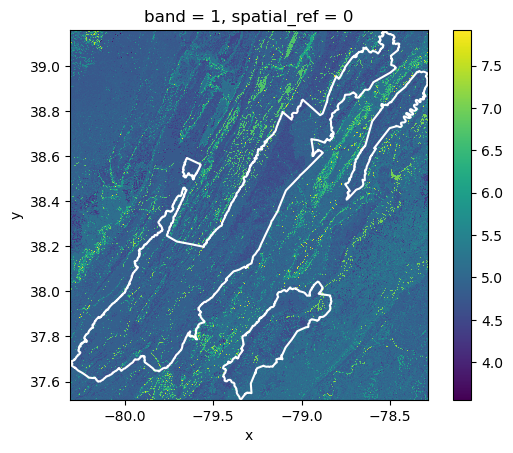

In [55]:
GWNF_soil_path = os.path.join(data_dir, 'polaris\GWNF\*.tif')
GWNF_ph_da = process_image(GWNF_soil_path, GWNF_gdf)
GWNF_ph_da.plot()
GWNF_gdf.boundary.plot(ax=plt.gca(), color='white')

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

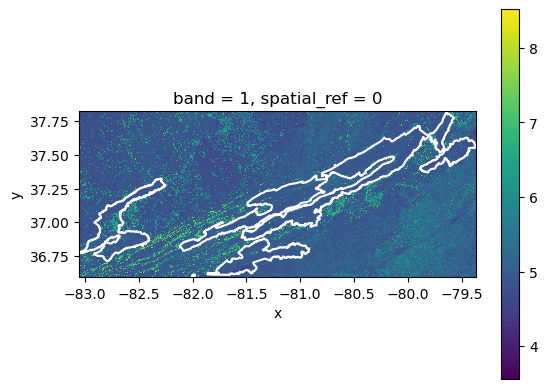

In [58]:
JNF_soil_path = os.path.join(data_dir, 'polaris\JNF\*.tif')
JNF_ph_da = process_image(JNF_soil_path, JNF_gdf)
JNF_ph_da.plot()
JNF_gdf.boundary.plot(ax=plt.gca(), color='white')

# Elevation Data
Elevation from the SRTM (available from the earthaccess API)

In [45]:
earthaccess.login()

In [61]:
# Search earthaccess for a suitable dataset
datasets = earthaccess.search_datasets(keyword='SRTMGL1')
for dataset in datasets:
    print(dataset['umm']['ShortName'], dataset['umm']['EntryTitle'])


SRTMGL1 NASA Shuttle Radar Topography Mission Global 1 arc second V003
SRTMGL3 NASA Shuttle Radar Topography Mission Global 3 arc second V003
SRTMGL1_NC NASA Shuttle Radar Topography Mission Global 1 arc second NetCDF V003
SRTMGL1N NASA Shuttle Radar Topography Mission Global 1 arc second number V003
SRTMGL1_NUMNC NASA Shuttle Radar Topography Mission Global 1 arc second Number NetCDF V003
SRTMGL3S NASA Shuttle Radar Topography Mission Global 3 arc second sub-sampled V003


In [ ]:
def srtm_data_download():
    

In [62]:
elevation_dir = os.path.join(data_dir, 'srtm')

os.makedirs(elevation_dir, exist_ok=True)

In [65]:
srtm_pattern = os.path.join(elevation_dir, '*.hgt.zip')

bounds_buffer = set_buffer(GWNF_gdf, 0.025)

if not glob(srtm_pattern):    
    
    srtm_results = earthaccess.search_data(
        short_name='SRTMGL1',
        bounding_box=bounds_buffer
    )
    srtm_results = earthaccess.download(srtm_results, elevation_dir)

In [66]:
srtm_da_list = []

for srtm_path in glob(srtm_pattern):
    tile_da = rxr.open_rasterio(srtm_path, mask_and_scale=True).squeeze()
    cropped_da = tile_da.rio.clip_box(*bounds_buffer)
    srtm_da_list.append(cropped_da)


srtm_da = rxrmerge.merge_arrays(srtm_da_list)

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

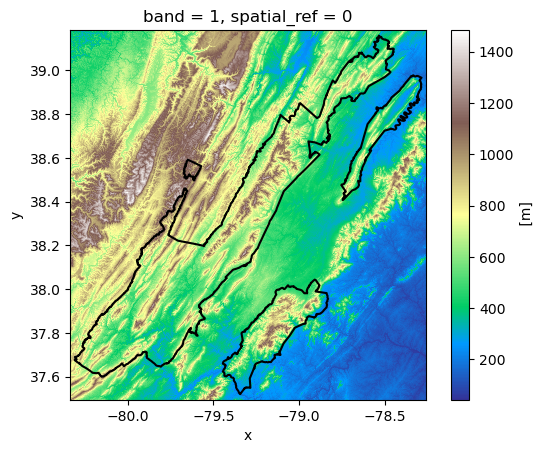

In [67]:
srtm_da.plot(cmap='terrain')
GWNF_gdf.boundary.plot(ax=plt.gca(), color='black')

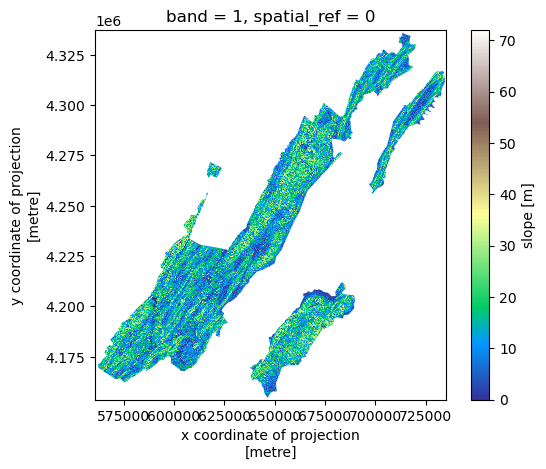

In [ ]:
# Reproject so units are in meters
epsg_utm17n = 32617
srtm_proj_da = srtm_da.rio.reproject(epsg_utm17n)
GWNF_proj_gdf = GWNF_gdf.to_crs(epsg_utm17n)
bounds_proj = tuple(GWNF_proj_gdf.total_bounds)

# Calculate rsxspatial.slope or .aspect
slope_full_da = xrspatial.slope(srtm_proj_da)
#slope_da = slope_full_da.rio.clip_box(*bounds_proj)
slope_da = slope_full_da.rio.clip(GWNF_proj_gdf.geometry)

# Plot slope
slope_da.plot(cmap='terrain')
GWNF_proj_gdf.boundary.plot(ax=plt.gca(), color='white')
plt.show()

# Climate Data
At least one climate variable from the MACAv2 THREDDS data server. Your project should compare two climate scenarios of your choice (e.g. different time periods, different emission scenarios). You can find a tutorial on how to access these climate data on earthdatascience.org

In [ ]:
def convert_longitude(longitude):
    """Convert longitude range from 0-360 to [-180:180]"""
    return (longitude - 360) if longitude > 180 else longitude

In [ ]:
maca_url = (
    'http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/BNU-ESM'
    '/macav2metdata_pr_BNU-ESM_r1i1p1_rcp85_2096_2099_CONUS_monthly.nc')
maca_da = xr.open_dataset(maca_url).squeeze().precipitation
# Reassign coordinates to [-180:180]
maca_da = maca_da.assign_coords(
    lon=("lon", [convert_longitude(l) for l in maca_da.lon.values])
)
maca_da = maca_da.rio.set_spatial_dims(x_dim='lon', y_dim='lat')
bounds = GWNF_gdf.to_crs(maca_da.rio.crs).total_bounds
maca_da = maca_da.rio.clip_box(*bounds)


<xarray.DataArray 'precipitation' (time: 48, lat: 585, lon: 1386)> Size: 156MB
[38918880 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 5kB 25.06 25.1 25.15 25.19 ... 49.27 49.31 49.35 49.4
    crs      int32 4B 1
  * lon      (lon) float64 11kB 235.2 235.3 235.3 235.4 ... 292.9 292.9 292.9
  * time     (time) object 384B 2096-01-15 00:00:00 ... 2099-12-15 00:00:00
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    grid_mapping:   crs
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [  8 115 276]

(array([1.0012e+04, 2.0686e+04, 2.6614e+04, 2.2077e+04, 1.0824e+04,
        3.6470e+03, 1.5840e+03, 3.8600e+02, 1.4400e+02, 2.6000e+01]),
 array([  2.11420488,  39.9983139 ,  77.8824234 , 115.7665329 ,
        153.65065002, 191.53475952, 229.41886902, 267.30297852,
        305.18707275, 343.07116699, 380.95529175]),
 <BarContainer object of 10 artists>)

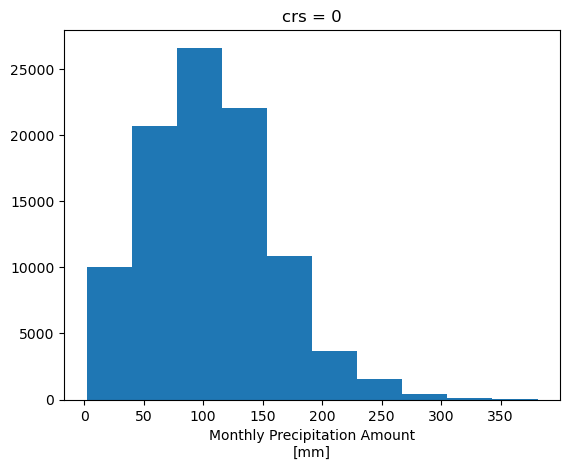

In [26]:
maca_da.plot()